In [7]:
# !python -V

In [8]:
import pandas as pd

In [9]:
import pickle

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [12]:
import mlflow
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc_taxi_experiment')

<Experiment: artifact_location='/Users/matthiasmotl/neuefische/repositories/dtc/dtc-mlops/02_experiment_tracking/mlruns/1', creation_time=1747236415301, experiment_id='1', last_update_time=1747236415301, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>

In [13]:
df = pd.read_parquet('../data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [14]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred) #, squared=False)

9.838799799829626

/var/folders/2p/knkmky2x69s7jl6b1s6y8s3r0000gn/T/ipykernel_9313/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/2p/knkmky2x69s7jl6b1s6y8s3r0000gn/T/ipykernel_9313/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label

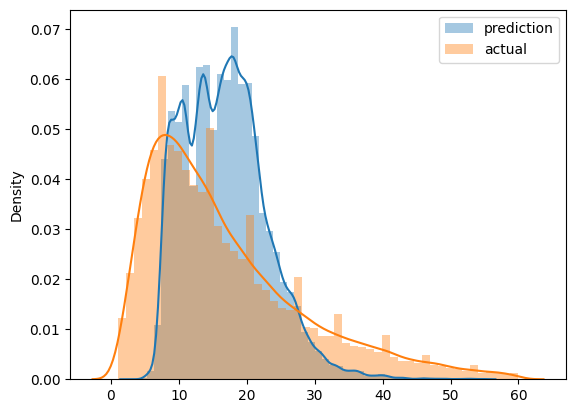

In [15]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [16]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [17]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [18]:
len(df_train), len(df_val)

(73908, 61921)

In [19]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [20]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred) #, squared=False)

7.758715201673044

In [23]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [24]:
with mlflow.start_run(): 

    mlflow.set_tag('developer', 'matthias')
    mlflow.log_param('train_data_path', '../data/green_tripdata_2021-01.parquet')
    mlflow.log_param('validation_data_path', '../data/green_tripdata_2021-02.parquet')

    alpha = 0.1
    mlflow.log_param('alpha', alpha)

    lr = Lasso(alpha)

    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred) #, squared=False)
    mlflow.log_metric('rmse', rmse)

MM XGBOOST

In [25]:
import xgboost as xgb

In [26]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [27]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [30]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)#, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [31]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:42:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:10.67969                          
[1]	validation-rmse:9.53094                           
[2]	validation-rmse:8.68143                           
[3]	validation-rmse:8.06625                           
[4]	validation-rmse:7.62347                           
[5]	validation-rmse:7.30927                           
[6]	validation-rmse:7.08616                           
[7]	validation-rmse:6.92905                           
[8]	validation-rmse:6.81260                           
[9]	validation-rmse:6.72917                           
[10]	validation-rmse:6.66861                          
[11]	validation-rmse:6.62274                          
[12]	validation-rmse:6.58954                          
[13]	validation-rmse:6.56362                          
[14]	validation-rmse:6.54383                          
[15]	validation-rmse:6.52807                          
[16]	validation-rmse:6.51511                          
[17]	validation-rmse:6.50408                          
[18]	valid

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:42:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:8.19000                                                    
[1]	validation-rmse:6.98875                                                    
[2]	validation-rmse:6.64530                                                    
[3]	validation-rmse:6.52924                                                    
[4]	validation-rmse:6.48537                                                    
[5]	validation-rmse:6.46231                                                    
[6]	validation-rmse:6.44969                                                    
[7]	validation-rmse:6.44053                                                    
[8]	validation-rmse:6.43131                                                    
[9]	validation-rmse:6.42409                                                    
[10]	validation-rmse:6.42187                                                   
[11]	validation-rmse:6.41653                                                   
[12]	validation-rmse:6.41076            

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:8.53530                                                    
[1]	validation-rmse:7.25713                                                    
[2]	validation-rmse:6.84600                                                    
[3]	validation-rmse:6.69788                                                    
[4]	validation-rmse:6.62981                                                    
[5]	validation-rmse:6.60663                                                    
[6]	validation-rmse:6.58144                                                    
[7]	validation-rmse:6.57197                                                    
[8]	validation-rmse:6.56249                                                    
[9]	validation-rmse:6.55714                                                    
[10]	validation-rmse:6.55372                                                   
[11]	validation-rmse:6.54889                                                   
[12]	validation-rmse:6.54312            

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:43:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:10.51482                                                   
[1]	validation-rmse:9.30909                                                    
[2]	validation-rmse:8.47172                                                    
[3]	validation-rmse:7.90055                                                    
[4]	validation-rmse:7.51540                                                    
[5]	validation-rmse:7.25838                                                    
[6]	validation-rmse:7.08627                                                    
[7]	validation-rmse:6.97173                                                    
[8]	validation-rmse:6.89148                                                    
[9]	validation-rmse:6.83544                                                    
[10]	validation-rmse:6.79400                                                   
[11]	validation-rmse:6.76673                                                   
[12]	validation-rmse:6.74693            

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:44:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:10.41814                                                   
[1]	validation-rmse:9.17032                                                    
[2]	validation-rmse:8.32287                                                    
[3]	validation-rmse:7.75877                                                    
[4]	validation-rmse:7.38900                                                    
[5]	validation-rmse:7.14581                                                    
[6]	validation-rmse:6.98487                                                    
[7]	validation-rmse:6.88015                                                    
[8]	validation-rmse:6.80793                                                    
[9]	validation-rmse:6.75635                                                    
[10]	validation-rmse:6.72060                                                   
[11]	validation-rmse:6.69283                                                   
[12]	validation-rmse:6.67320            

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:45:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.02218                                                   
[1]	validation-rmse:10.06429                                                   
[2]	validation-rmse:9.30453                                                    
[3]	validation-rmse:8.71420                                                    
[4]	validation-rmse:8.22693                                                    
[5]	validation-rmse:7.86839                                                    
[6]	validation-rmse:7.56921                                                    
[7]	validation-rmse:7.34979                                                    
[8]	validation-rmse:7.18096                                                    
[9]	validation-rmse:7.04800                                                    
[10]	validation-rmse:6.93903                                                   
[11]	validation-rmse:6.86174                                                   
[12]	validation-rmse:6.79670            

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:46:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.18117                                                   
[1]	validation-rmse:10.31976                                                   
[2]	validation-rmse:9.60670                                                    
[3]	validation-rmse:9.01863                                                    
[4]	validation-rmse:8.53500                                                    
[5]	validation-rmse:8.14517                                                    
[6]	validation-rmse:7.82825                                                    
[7]	validation-rmse:7.57318                                                    
[8]	validation-rmse:7.36508                                                    
[9]	validation-rmse:7.19944                                                    
[10]	validation-rmse:7.06524                                                   
[11]	validation-rmse:6.95959                                                   
[12]	validation-rmse:6.87230            

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:47:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[4]	validation-rmse:6.75044                                                    
[5]	validation-rmse:6.74213                                                    
[6]	validation-rmse:6.73521                                                    
[7]	validation-rmse:6.72941                                                    
[8]	validation-rmse:6.72004                                                    
[9]	validation-rmse:6.71542                                                    
[10]	validation-rmse:6.71093                                                   
[11]	validation-rmse:6.70705                                                   
[12]	validation-rmse:6.70264                                                   
[13]	validation-rmse:6.69667                                                   
[14]	validation-rmse:6.69316                                                   
[15]	validation-rmse:6.69117                                                   
[16]	validation-rmse:6.68958            

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:48:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:7.36366                                                    
[1]	validation-rmse:6.78751                                                    
[2]	validation-rmse:6.70260                                                    
[3]	validation-rmse:6.67768                                                    
[4]	validation-rmse:6.66867                                                    
[5]	validation-rmse:6.66253                                                    
[6]	validation-rmse:6.65090                                                    
[7]	validation-rmse:6.64181                                                    
[8]	validation-rmse:6.63409                                                    
[9]	validation-rmse:6.62902                                                    
[10]	validation-rmse:6.62385                                                   
[11]	validation-rmse:6.62101                                                   
[12]	validation-rmse:6.61407            

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:48:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:6.97135                                                    
[1]	validation-rmse:6.60529                                                    
[2]	validation-rmse:6.55470                                                    
[3]	validation-rmse:6.54068                                                    
[4]	validation-rmse:6.53228                                                    
[5]	validation-rmse:6.52567                                                    
[6]	validation-rmse:6.51079                                                    
[7]	validation-rmse:6.50205                                                    
[8]	validation-rmse:6.49773                                                    
[9]	validation-rmse:6.48303                                                    
[10]	validation-rmse:6.47684                                                   
[11]	validation-rmse:6.47018                                                   
[12]	validation-rmse:6.46728            

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:48:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:6.99676                                                     
[1]	validation-rmse:6.68768                                                     
[2]	validation-rmse:6.63966                                                     
[3]	validation-rmse:6.62823                                                     
[4]	validation-rmse:6.61678                                                     
[5]	validation-rmse:6.60360                                                     
[6]	validation-rmse:6.59874                                                     
[7]	validation-rmse:6.59280                                                     
[8]	validation-rmse:6.58873                                                     
[9]	validation-rmse:6.58576                                                     
[10]	validation-rmse:6.58130                                                    
[11]	validation-rmse:6.57313                                                    
[12]	validation-rmse:6.57184

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:49:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:9.30670                                                     
[1]	validation-rmse:7.88147                                                     
[2]	validation-rmse:7.21487                                                     
[3]	validation-rmse:6.91844                                                     
[4]	validation-rmse:6.76698                                                     
[5]	validation-rmse:6.68958                                                     
[6]	validation-rmse:6.64742                                                     
[7]	validation-rmse:6.62392                                                     
[8]	validation-rmse:6.60682                                                     
[9]	validation-rmse:6.59747                                                     
[10]	validation-rmse:6.58750                                                    
[11]	validation-rmse:6.58312                                                    
[12]	validation-rmse:6.57784

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:49:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[1]	validation-rmse:10.67954                                                    
[2]	validation-rmse:10.06771                                                    
[3]	validation-rmse:9.54291                                                     
[4]	validation-rmse:9.09571                                                     
[5]	validation-rmse:8.71605                                                     
[6]	validation-rmse:8.39453                                                     
[7]	validation-rmse:8.12349                                                     
[8]	validation-rmse:7.89569                                                     
[9]	validation-rmse:7.70368                                                     
[10]	validation-rmse:7.54282                                                    
[11]	validation-rmse:7.40835                                                    
[12]	validation-rmse:7.29561                                                    
[13]	validation-rmse:7.20125

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:50:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:8.74255                                                     
[1]	validation-rmse:7.33660                                                     
[2]	validation-rmse:6.81275                                                     
[3]	validation-rmse:6.60684                                                     
[4]	validation-rmse:6.52364                                                     
[5]	validation-rmse:6.48094                                                     
[6]	validation-rmse:6.45671                                                     
[7]	validation-rmse:6.44079                                                     
[8]	validation-rmse:6.43335                                                     
[9]	validation-rmse:6.42776                                                     
[10]	validation-rmse:6.42323                                                    
[11]	validation-rmse:6.41715                                                    
[12]	validation-rmse:6.41279

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:50:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[1]	validation-rmse:10.22398                                                    
[2]	validation-rmse:9.49968                                                     
[3]	validation-rmse:8.91774                                                     
[4]	validation-rmse:8.45434                                                     
[5]	validation-rmse:8.08680                                                     
[6]	validation-rmse:7.79670                                                     
[7]	validation-rmse:7.56896                                                     
[8]	validation-rmse:7.38994                                                     
[9]	validation-rmse:7.24998                                                     
[10]	validation-rmse:7.14089                                                    
[11]	validation-rmse:7.05521                                                    
[12]	validation-rmse:6.98841                                                    
[13]	validation-rmse:6.93372

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:52:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:8.95992                                                     
[1]	validation-rmse:7.60172                                                     
[2]	validation-rmse:7.07115                                                     
[3]	validation-rmse:6.86561                                                     
[4]	validation-rmse:6.76997                                                     
[5]	validation-rmse:6.72559                                                     
[6]	validation-rmse:6.70225                                                     
[7]	validation-rmse:6.68005                                                     
[8]	validation-rmse:6.66998                                                     
[9]	validation-rmse:6.66490                                                     
[10]	validation-rmse:6.65987                                                    
[11]	validation-rmse:6.65677                                                    
[12]	validation-rmse:6.65468

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:52:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:7.19904                                                     
[1]	validation-rmse:6.69012                                                     
[2]	validation-rmse:6.61437                                                     
[3]	validation-rmse:6.60108                                                     
[4]	validation-rmse:6.58871                                                     
[5]	validation-rmse:6.58222                                                     
[6]	validation-rmse:6.57601                                                     
[7]	validation-rmse:6.56960                                                     
[8]	validation-rmse:6.56439                                                     
[9]	validation-rmse:6.55810                                                     
[10]	validation-rmse:6.54989                                                    
[11]	validation-rmse:6.54605                                                    
[12]	validation-rmse:6.54104

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:52:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.60749                                                    
[1]	validation-rmse:11.06083                                                    
[2]	validation-rmse:10.56886                                                    
[3]	validation-rmse:10.12535                                                    
[4]	validation-rmse:9.72928                                                     
[5]	validation-rmse:9.37407                                                     
[6]	validation-rmse:9.05637                                                     
[7]	validation-rmse:8.77228                                                     
[8]	validation-rmse:8.52100                                                     
[9]	validation-rmse:8.29617                                                     
[10]	validation-rmse:8.09839                                                    
[11]	validation-rmse:7.92143                                                    
[12]	validation-rmse:7.76595

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:54:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:10.10088                                                    
[1]	validation-rmse:8.75409                                                     
[2]	validation-rmse:7.90577                                                     
[3]	validation-rmse:7.39762                                                     
[4]	validation-rmse:7.08004                                                     
[5]	validation-rmse:6.88681                                                     
[6]	validation-rmse:6.77641                                                     
[7]	validation-rmse:6.70112                                                     
[8]	validation-rmse:6.64014                                                     
[9]	validation-rmse:6.60333                                                     
[10]	validation-rmse:6.58017                                                    
[11]	validation-rmse:6.56100                                                    
[12]	validation-rmse:6.54795

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:54:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:6.99253                                                     
[1]	validation-rmse:6.60518                                                     
[2]	validation-rmse:6.55962                                                     
[3]	validation-rmse:6.55606                                                     
[4]	validation-rmse:6.54213                                                     
[5]	validation-rmse:6.53876                                                     
[6]	validation-rmse:6.52358                                                     
[7]	validation-rmse:6.51671                                                     
[8]	validation-rmse:6.51180                                                     
[9]	validation-rmse:6.50259                                                     
[10]	validation-rmse:6.49171                                                    
[11]	validation-rmse:6.48773                                                    
[12]	validation-rmse:6.48375

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:55:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.78176                                                    
[1]	validation-rmse:11.37990                                                    
[2]	validation-rmse:11.00580                                                    
[3]	validation-rmse:10.65799                                                    
[4]	validation-rmse:10.33483                                                    
[5]	validation-rmse:10.03482                                                    
[6]	validation-rmse:9.75689                                                     
[7]	validation-rmse:9.49954                                                     
[8]	validation-rmse:9.26160                                                     
[9]	validation-rmse:9.04165                                                     
[10]	validation-rmse:8.83845                                                    
[11]	validation-rmse:8.65089                                                    
[12]	validation-rmse:8.47823

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:56:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[1]	validation-rmse:11.26182                                                    
[2]	validation-rmse:10.84284                                                    
[3]	validation-rmse:10.45931                                                    
[4]	validation-rmse:10.10749                                                    
[5]	validation-rmse:9.78539                                                     
[6]	validation-rmse:9.49151                                                     
[7]	validation-rmse:9.22382                                                     
[8]	validation-rmse:8.97953                                                     
[9]	validation-rmse:8.75780                                                     
[10]	validation-rmse:8.55641                                                    
[11]	validation-rmse:8.37388                                                    
[12]	validation-rmse:8.20809                                                    
[13]	validation-rmse:8.05758

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:57:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.59207                                                    
[1]	validation-rmse:11.03162                                                    
[2]	validation-rmse:10.52760                                                    
[3]	validation-rmse:10.07418                                                    
[4]	validation-rmse:9.67002                                                     
[5]	validation-rmse:9.30790                                                     
[6]	validation-rmse:8.98401                                                     
[7]	validation-rmse:8.69547                                                     
[8]	validation-rmse:8.44025                                                     
[9]	validation-rmse:8.21323                                                     
[10]	validation-rmse:8.01203                                                    
[11]	validation-rmse:7.83422                                                    
[12]	validation-rmse:7.67811

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:00:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.47343                                                    
[1]	validation-rmse:10.81963                                                    
[2]	validation-rmse:10.24584                                                    
[3]	validation-rmse:9.74215                                                     
[4]	validation-rmse:9.30168                                                     
[5]	validation-rmse:8.91732                                                     
[6]	validation-rmse:8.58247                                                     
[7]	validation-rmse:8.29293                                                     
[8]	validation-rmse:8.04407                                                     
[9]	validation-rmse:7.82763                                                     
[10]	validation-rmse:7.64284                                                    
[11]	validation-rmse:7.48222                                                    
[12]	validation-rmse:7.34512

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:02:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.31735                                                    
[1]	validation-rmse:10.55634                                                    
[2]	validation-rmse:9.90655                                                     
[3]	validation-rmse:9.35391                                                     
[4]	validation-rmse:8.89306                                                     
[5]	validation-rmse:8.50055                                                     
[6]	validation-rmse:8.17762                                                     
[7]	validation-rmse:7.90747                                                     
[8]	validation-rmse:7.68074                                                     
[9]	validation-rmse:7.49666                                                     
[10]	validation-rmse:7.34215                                                    
[11]	validation-rmse:7.21371                                                    
[12]	validation-rmse:7.10926

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:06:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.78316                                                     
[1]	validation-rmse:11.38212                                                     
[2]	validation-rmse:11.00844                                                     
[3]	validation-rmse:10.66085                                                     
[4]	validation-rmse:10.33816                                                     
[5]	validation-rmse:10.03751                                                     
[6]	validation-rmse:9.76020                                                      
[7]	validation-rmse:9.50260                                                      
[8]	validation-rmse:9.26391                                                      
[9]	validation-rmse:9.04247                                                      
[10]	validation-rmse:8.83716                                                     
[11]	validation-rmse:8.64857                                                     
[12]	validation-

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:08:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.63243                                                     
[1]	validation-rmse:11.10537                                                     
[2]	validation-rmse:10.62773                                                     
[3]	validation-rmse:10.19569                                                     
[4]	validation-rmse:9.80575                                                      
[5]	validation-rmse:9.45472                                                      
[6]	validation-rmse:9.13919                                                      
[7]	validation-rmse:8.85563                                                      
[8]	validation-rmse:8.60204                                                      
[9]	validation-rmse:8.37492                                                      
[10]	validation-rmse:8.17254                                                     
[11]	validation-rmse:7.99204                                                     
[12]	validation-

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:10:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.06647                                                     
[1]	validation-rmse:10.13534                                                     
[2]	validation-rmse:9.38518                                                      
[3]	validation-rmse:8.78544                                                      
[4]	validation-rmse:8.31175                                                      
[5]	validation-rmse:7.93887                                                      
[6]	validation-rmse:7.64745                                                      
[7]	validation-rmse:7.42175                                                      
[8]	validation-rmse:7.24405                                                      
[9]	validation-rmse:7.10514                                                      
[10]	validation-rmse:6.99698                                                     
[11]	validation-rmse:6.91199                                                     
[12]	validation-

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:11:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:9.86439                                                      
[1]	validation-rmse:8.46334                                                      
[2]	validation-rmse:7.66358                                                      
[3]	validation-rmse:7.20828                                                      
[4]	validation-rmse:6.95756                                                      
[5]	validation-rmse:6.80898                                                      
[6]	validation-rmse:6.71556                                                      
[7]	validation-rmse:6.65853                                                      
[8]	validation-rmse:6.62936                                                      
[9]	validation-rmse:6.60740                                                      
[10]	validation-rmse:6.59251                                                     
[11]	validation-rmse:6.58187                                                     
[12]	validation-

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:12:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:10.82210                                                    
[1]	validation-rmse:9.74026                                                     
[2]	validation-rmse:8.91200                                                     
[3]	validation-rmse:8.28163                                                     
[4]	validation-rmse:7.81287                                                     
[5]	validation-rmse:7.46121                                                     
[6]	validation-rmse:7.20172                                                     
[7]	validation-rmse:7.01081                                                     
[8]	validation-rmse:6.87196                                                     
[9]	validation-rmse:6.76882                                                     
[10]	validation-rmse:6.68899                                                    
[11]	validation-rmse:6.63135                                                    
[12]	validation-rmse:6.58752

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:13:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.52393                                                    
[1]	validation-rmse:10.90965                                                    
[2]	validation-rmse:10.36439                                                    
[3]	validation-rmse:9.88029                                                     
[4]	validation-rmse:9.45301                                                     
[5]	validation-rmse:9.07708                                                     
[6]	validation-rmse:8.74691                                                     
[7]	validation-rmse:8.45752                                                     
[8]	validation-rmse:8.20400                                                     
[9]	validation-rmse:7.98295                                                     
[10]	validation-rmse:7.79085                                                    
[11]	validation-rmse:7.62372                                                    
[12]	validation-rmse:7.47860

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:15:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.25783                                                    
[1]	validation-rmse:10.45298                                                    
[2]	validation-rmse:9.77998                                                     
[3]	validation-rmse:9.22000                                                     
[4]	validation-rmse:8.75331                                                     
[5]	validation-rmse:8.36954                                                     
[6]	validation-rmse:8.05682                                                     
[7]	validation-rmse:7.79862                                                     
[8]	validation-rmse:7.59113                                                     
[9]	validation-rmse:7.41883                                                     
[10]	validation-rmse:7.27956                                                    
[11]	validation-rmse:7.16761                                                    
[12]	validation-rmse:7.07436

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:16:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.68949                                                    
[1]	validation-rmse:11.20831                                                    
[2]	validation-rmse:10.76742                                                    
[3]	validation-rmse:10.36356                                                    
[4]	validation-rmse:9.99494                                                     
[5]	validation-rmse:9.65789                                                     
[6]	validation-rmse:9.35163                                                     
[7]	validation-rmse:9.07331                                                     
[8]	validation-rmse:8.81945                                                     
[9]	validation-rmse:8.58846                                                     
[10]	validation-rmse:8.37953                                                    
[11]	validation-rmse:8.19098                                                    
[12]	validation-rmse:8.01966

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:18:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:10.80767                                                    
[1]	validation-rmse:9.72224                                                     
[2]	validation-rmse:8.89541                                                     
[3]	validation-rmse:8.27352                                                     
[4]	validation-rmse:7.81064                                                     
[5]	validation-rmse:7.46903                                                     
[6]	validation-rmse:7.21711                                                     
[7]	validation-rmse:7.03439                                                     
[8]	validation-rmse:6.89972                                                     
[9]	validation-rmse:6.79947                                                     
[10]	validation-rmse:6.72456                                                    
[11]	validation-rmse:6.66751                                                    
[12]	validation-rmse:6.62486

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:19:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:10.65446                                                    
[1]	validation-rmse:9.49984                                                     
[2]	validation-rmse:8.66074                                                     
[3]	validation-rmse:8.06107                                                     
[4]	validation-rmse:7.62791                                                     
[5]	validation-rmse:7.33474                                                     
[6]	validation-rmse:7.12323                                                     
[7]	validation-rmse:6.96409                                                     
[8]	validation-rmse:6.86081                                                     
[9]	validation-rmse:6.78614                                                     
[10]	validation-rmse:6.73059                                                    
[11]	validation-rmse:6.68390                                                    
[12]	validation-rmse:6.65486

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:20:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.45944                                                    
[1]	validation-rmse:10.80084                                                    
[2]	validation-rmse:10.22182                                                    
[3]	validation-rmse:9.71855                                                     
[4]	validation-rmse:9.27759                                                     
[5]	validation-rmse:8.90190                                                     
[6]	validation-rmse:8.57388                                                     
[7]	validation-rmse:8.29177                                                     
[8]	validation-rmse:8.05046                                                     
[9]	validation-rmse:7.84139                                                     
[10]	validation-rmse:7.66511                                                    
[11]	validation-rmse:7.51291                                                    
[12]	validation-rmse:7.38413

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:55:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.17274                                                         
[1]	validation-rmse:10.30601                                                         
[2]	validation-rmse:9.58631                                                          
[3]	validation-rmse:8.99541                                                          
[4]	validation-rmse:8.51198                                                          
[5]	validation-rmse:8.11725                                                          
[6]	validation-rmse:7.79971                                                          
[7]	validation-rmse:7.54385                                                          
[8]	validation-rmse:7.33838                                                          
[9]	validation-rmse:7.17441                                                          
[10]	validation-rmse:7.04156                                                         
[11]	validation-rmse:6.93721                          

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:07:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:10.20084                                                         
[1]	validation-rmse:8.85603                                                          
[2]	validation-rmse:7.98563                                                          
[3]	validation-rmse:7.43441                                                          
[4]	validation-rmse:7.08605                                                          
[5]	validation-rmse:6.87194                                                          
[6]	validation-rmse:6.72951                                                          
[7]	validation-rmse:6.64044                                                          
[8]	validation-rmse:6.58251                                                          
[9]	validation-rmse:6.54280                                                          
[10]	validation-rmse:6.50979                                                         
[11]	validation-rmse:6.48843                          

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:07:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:10.90413                                                         
[1]	validation-rmse:9.87255                                                          
[2]	validation-rmse:9.06846                                                          
[3]	validation-rmse:8.44742                                                          
[4]	validation-rmse:7.97344                                                          
[5]	validation-rmse:7.61338                                                          
[6]	validation-rmse:7.34404                                                          
[7]	validation-rmse:7.13974                                                          
[8]	validation-rmse:6.98876                                                          
[9]	validation-rmse:6.87238                                                          
[10]	validation-rmse:6.78259                                                         
[11]	validation-rmse:6.71503                          

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:08:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:9.79228                                                          
[1]	validation-rmse:8.37911                                                          
[2]	validation-rmse:7.58655                                                          
[3]	validation-rmse:7.15974                                                          
[4]	validation-rmse:6.92451                                                          
[5]	validation-rmse:6.79397                                                          
[6]	validation-rmse:6.71743                                                          
[7]	validation-rmse:6.67161                                                          
[8]	validation-rmse:6.64214                                                          
[9]	validation-rmse:6.62012                                                          
[10]	validation-rmse:6.60725                                                         
[11]	validation-rmse:6.59892                          

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:09:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:6.77330                                                        
[1]	validation-rmse:6.75147                                                        
[2]	validation-rmse:6.73333                                                        
[3]	validation-rmse:6.71583                                                        
[4]	validation-rmse:6.71607                                                        
[5]	validation-rmse:6.70728                                                        
[6]	validation-rmse:6.70202                                                        
[7]	validation-rmse:6.70133                                                        
[8]	validation-rmse:6.69350                                                        
[9]	validation-rmse:6.69040                                                        
[10]	validation-rmse:6.68701                                                       
[11]	validation-rmse:6.68466                                                

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:09:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[1]	validation-rmse:9.44295                                                        
[2]	validation-rmse:8.60892                                                        
[3]	validation-rmse:8.02513                                                        
[4]	validation-rmse:7.61831                                                        
[5]	validation-rmse:7.34134                                                        
[6]	validation-rmse:7.15015                                                        
[7]	validation-rmse:7.01345                                                        
[8]	validation-rmse:6.91746                                                        
[9]	validation-rmse:6.85211                                                        
[10]	validation-rmse:6.80376                                                       
[11]	validation-rmse:6.77080                                                       
[12]	validation-rmse:6.74585                                                

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:10:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.39017                                                       
[1]	validation-rmse:10.67533                                                       
[2]	validation-rmse:10.05522                                                       
[3]	validation-rmse:9.52100                                                        
[4]	validation-rmse:9.06167                                                        
[5]	validation-rmse:8.66987                                                        
[6]	validation-rmse:8.33364                                                        
[7]	validation-rmse:8.05009                                                        
[8]	validation-rmse:7.81053                                                        
[9]	validation-rmse:7.60561                                                        
[10]	validation-rmse:7.43477                                                       
[11]	validation-rmse:7.29048                                                

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:12:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.61522                                                       
[1]	validation-rmse:11.07448                                                       
[2]	validation-rmse:10.58860                                                       
[3]	validation-rmse:10.14954                                                       
[4]	validation-rmse:9.75864                                                        
[5]	validation-rmse:9.40864                                                        
[6]	validation-rmse:9.09300                                                        
[7]	validation-rmse:8.81166                                                        
[8]	validation-rmse:8.56303                                                        
[9]	validation-rmse:8.34211                                                        
[10]	validation-rmse:8.14438                                                       
[11]	validation-rmse:7.96960                                                

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:13:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:7.78520                                                        
[1]	validation-rmse:6.79532                                                        
[2]	validation-rmse:6.57696                                                        
[3]	validation-rmse:6.50511                                                        
[4]	validation-rmse:6.47732                                                        
[5]	validation-rmse:6.46118                                                        
[6]	validation-rmse:6.45058                                                        
[7]	validation-rmse:6.44305                                                        
[8]	validation-rmse:6.43842                                                        
[9]	validation-rmse:6.43309                                                        
[10]	validation-rmse:6.42336                                                       
[11]	validation-rmse:6.41969                                                

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:14:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.70625                                                      
[1]	validation-rmse:11.23959                                                      
[2]	validation-rmse:10.81223                                                      
[3]	validation-rmse:10.41936                                                      
[4]	validation-rmse:10.05976                                                      
[5]	validation-rmse:9.73078                                                       
[6]	validation-rmse:9.43026                                                       
[7]	validation-rmse:9.15628                                                       
[8]	validation-rmse:8.90732                                                       
[9]	validation-rmse:8.68134                                                       
[10]	validation-rmse:8.47662                                                      
[11]	validation-rmse:8.29021                                                      
[12]

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:15:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.53003                                                      
[1]	validation-rmse:10.92057                                                      
[2]	validation-rmse:10.37837                                                      
[3]	validation-rmse:9.89785                                                       
[4]	validation-rmse:9.47219                                                       
[5]	validation-rmse:9.09448                                                       
[6]	validation-rmse:8.76294                                                       
[7]	validation-rmse:8.47192                                                       
[8]	validation-rmse:8.21582                                                       
[9]	validation-rmse:7.99196                                                       
[10]	validation-rmse:7.79710                                                      
[11]	validation-rmse:7.62670                                                      
[12]

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:17:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:11.80978                                                      
[1]	validation-rmse:11.43271                                                      
[2]	validation-rmse:11.08064                                                      
[3]	validation-rmse:10.75212                                                      
[4]	validation-rmse:10.44600                                                      
[5]	validation-rmse:10.16095                                                      
[6]	validation-rmse:9.89554                                                       
[7]	validation-rmse:9.64883                                                       
[8]	validation-rmse:9.41964                                                       
[9]	validation-rmse:9.20708                                                       
[10]	validation-rmse:9.01017                                                      
[11]	validation-rmse:8.82793                                                      
[12]

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:18:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[0]	validation-rmse:10.43221                                                      
[1]	validation-rmse:9.18586                                                       
[2]	validation-rmse:8.34062                                                       
[3]	validation-rmse:7.76463                                                       
[4]	validation-rmse:7.38563                                                       
[5]	validation-rmse:7.13655                                                       
[6]	validation-rmse:6.96536                                                       
[7]	validation-rmse:6.85077                                                       
[8]	validation-rmse:6.77051                                                       
[9]	validation-rmse:6.71557                                                       
[10]	validation-rmse:6.67863                                                      
[11]	validation-rmse:6.64702                                                      
[12]

/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:19:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)



[4]	validation-rmse:8.61562                                                       
[5]	validation-rmse:8.24827                                                       
[6]	validation-rmse:7.95409                                                       
[7]	validation-rmse:7.71914                                                       
[8]	validation-rmse:7.53369                                                       
[9]	validation-rmse:7.38660                                                       
[10]	validation-rmse:7.26817                                                      
[11]	validation-rmse:7.17471                                                      
[12]	validation-rmse:7.09942                                                      
[13]	validation-rmse:7.03984                                                      
[14]	validation-rmse:6.99124                                                      
[15]	validation-rmse:6.95362                                                      
[16]

In [32]:
params = {
    "learning_rate": 0.06250345613117511,
    "max_depth": 43,
    "min_child_weight": 1.4898346923239079,
    "objective": "reg:linear",
    "reg_alpha": 0.013267037520848521,
    "reg_lambda": 0.005200771650703148,
    "seed": 42
    }

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,   
    evals=[(valid, 'validation')],
    early_stopping_rounds=1000)

2025/05/15 11:41:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c962a51a4a8a49a28d8ff88230b91a8f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:41:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  print(smsg)


[0]	validation-rmse:11.70625
[1]	validation-rmse:11.23959
[2]	validation-rmse:10.81223
[3]	validation-rmse:10.41936
[4]	validation-rmse:10.05976
[5]	validation-rmse:9.73078
[6]	validation-rmse:9.43026
[7]	validation-rmse:9.15628
[8]	validation-rmse:8.90732
[9]	validation-rmse:8.68134
[10]	validation-rmse:8.47662
[11]	validation-rmse:8.29021
[12]	validation-rmse:8.12108
[13]	validation-rmse:7.96851
[14]	validation-rmse:7.83122
[15]	validation-rmse:7.70750
[16]	validation-rmse:7.59350
[17]	validation-rmse:7.49121
[18]	validation-rmse:7.39889
[19]	validation-rmse:7.31647
[20]	validation-rmse:7.24130
[21]	validation-rmse:7.17276
[22]	validation-rmse:7.11166
[23]	validation-rmse:7.05600
[24]	validation-rmse:7.00633
[25]	validation-rmse:6.96141
[26]	validation-rmse:6.92028
[27]	validation-rmse:6.88344
[28]	validation-rmse:6.84937
[29]	validation-rmse:6.81857
[30]	validation-rmse:6.79104
[31]	validation-rmse:6.76597
[32]	validation-rmse:6.74291
[33]	validation-rmse:6.72160
[34]	validation-rms

2025/05/15 11:43:23 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/15 11:43:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/matthiasmotl/opt/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:43:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1703076406455/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2025/05/15 11:44:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'copy_X': 'True',
 'fit_intercept': 'True',
 'n_jobs': 'None',
 'positive': 'False'}
{'training_mean_absolute_error': 0.0,
 'training_mean_squared_error': 0.0,
 'training_r2_score': 1.0,
 'training_root_mean_squared_error': 0.0,
 'training_score': 1.0}
{'estimator_class': 'sklearn.linear_model._base.LinearRegression',
 'estimator_name': 'LinearRegression'}
['model/MLmodel',
 'model/conda.yaml',
 'model/model.pkl',
 'model/python_env.yaml',
 'model/requirements.txt']
